In [126]:
import matplotlib.pyplot as plt
import DMK_go_coude as Fns
import numpy as np
import os, readcol
import scipy.optimize as optim
import scipy.interpolate as interp
import pickle

from astropy.io import fits 
from mpfit import mpfit
from scipy import signal

%matplotlib inline

In [2]:
dir = os.getenv("HOME") + '/Research/YMG/coude_data/20140321/'
rdir = dir + 'reduction/'
#codedir = os.getenv("HOME") + '/codes/tullcoude/'
codedir = os.getenv("HOME") + '/Research/Codes/coudereduction/'

In [3]:
os.chdir(dir)

In [4]:
DarkCurVal = 0.0

InfoFile = 'headstrip.csv'
FileInfo = readcol.readcol( InfoFile, fsep = ',', asRecArray = True )
DarkCube = FileInfo.ExpTime * DarkCurVal

In [5]:
BiasInds = np.where( FileInfo.Type == 'zero' )[0]
FlatInds = np.where( FileInfo.Type == 'flat' )[0]
ArcInds  = np.where( (FileInfo.Type == 'comp') & ( (FileInfo.Object == 'Thar') | (FileInfo.Object == 'THAR') | (FileInfo.Object == 'A') ) )[0]
ObjInds  = np.where( (FileInfo.Type == 'object') & (FileInfo.Object != 'SolPort') & (FileInfo.Object != 'solar port') & (FileInfo.Object != 'solar_ort') )[0]

In [6]:
CalsDone = True
SuperBias, FlatField = Fns.Basic_Cals( FileInfo.File[BiasInds], FileInfo.File[FlatInds], CalsDone, rdir, plots = False )

Reading in premade Bias and Flat files


In [7]:
ShowBPM = False
BPM = Fns.Make_BPM( SuperBias, FlatField, 99.9, ShowBPM )

In [8]:
RdNoise  = FileInfo.rdn[ArcInds] / FileInfo.gain[ArcInds]
DarkCur  = DarkCube[ArcInds] / FileInfo.gain[ArcInds]
ArcCube, ArcSNR = Fns.Make_Cube( FileInfo.File[ArcInds], RdNoise, DarkCur, Bias = SuperBias )

RdNoise  = FileInfo.rdn[ObjInds] / FileInfo.gain[ObjInds]
DarkCur  = DarkCube[ObjInds] / FileInfo.gain[ObjInds]
ObjCube, ObjSNR = Fns.Make_Cube( FileInfo.File[ObjInds], RdNoise, DarkCur, Bias = SuperBias, Flat = FlatField, BPM = BPM )

DMK_go_coude.py:131: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
DMK_go_coude.py:132: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
DMK_go_coude.py:132: RuntimeWarning: divide by zero encountered in divide
DMK_go_coude.py:132: RuntimeWarning: invalid value encountered in divide
/Users/boydrummer94/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [9]:
OrderStart = -32
TraceDone = True
MedCut = 95.0
MedTrace, FitTrace = Fns.Get_Trace( FlatField, ObjCube, OrderStart, MedCut, rdir, TraceDone, plots = False )

Reading in premade Trace and plotting on Flat:


In [10]:
#fullspec, fullsig_spec = Fns.extractor( ObjCube, ObjSNR, FitTrace, quick = False, nosub = False, arc = False )

In [11]:
spec     = pickle.load(open(rdir+'extracted_spec_oldway.pkl','rb'))
sig_spec = pickle.load(open(rdir+'extracted_sigspec_oldway.pkl','rb'))
wspec     = pickle.load(open(rdir+'extracted_wspec_oldway.pkl','rb'))
sig_wspec = pickle.load(open(rdir+'extracted_sigwspec_oldway.pkl','rb'))

In [12]:
wspec      = wspec[:,::-1,:]
sig_wspec  = sig_wspec[:,::-1,:]
spec       = spec[:,::-1,:]
sig_spec   = sig_spec[:,::-1,:]

In [13]:
# This is finding peaks using the scipy signal routine
#peakind = signal.find_peaks_cwt( np.log10(wspec[0,startorder,:]), np.arange( 1, 50 ) )
#
#plt.clf()
#plt.plot( np.log10(wspec[0,startorder,:]), 'k-' )
#for peak in peakind:
#    plt.axvline( x = peak, color = 'r' )
#plt.show()

In [20]:
THAR      = fits.open( codedir + 'thar_photron.fits' )[0]
THARhead  = THAR.header
THARspec  = THAR.data
THARwav   = np.arange( len( THARspec ) ) * THARhead['CDELT1'] + THARhead['CRVAL1']
THARlines = readcol.readcol( codedir + 'ThAr_list.txt', asRecArray = True )

#qwe            = np.where((THARwav >= np.min(roughwav-10)) & (THARwav <= np.max(roughwav+10)))[0] 
#ls             = THARspec[qwe] - np.min(THARspec[qwe])
#region         = np.where(ls < np.median(ls))
#ls[region]     = np.median(ls)

Removing 1 rows that don't match most common length 2.                       
4168 rows read into array.


In [42]:
roughdisp  = 7000.0 / 60000.0 / 2.0
wavestart  = 6957.0
startorder = wspec.shape[1] - 15 - 1
arcspec    = wspec[0,startorder,:]
roughwav   = wavestart + roughdisp * np.arange( len( arcspec ) )

arcspec           = arcspec - np.min( arcspec )
belowmed          = np.where( arcspec < np.median( arcspec ) )
arcspec[belowmed] = np.median( arcspec )
logarcspec        = np.log10( arcspec )
logarcspec        = logarcspec - np.min( logarcspec )

In [17]:
newspec = np.log10(norder) - np.min(np.log10(norder))
thresh = np.percentile( newspec, 97 )
above  = np.where( newspec >= thresh )[0]

In [18]:
def Gaussian( x, A, mean, sigma, const ):
    return A * np.exp( - ( x - mean ) ** 2.0 / ( 2.0 * sigma ** 2 ) ) + const

In [65]:
def find_peaks( wav, spec, pwidth = 10, plevel = 97, minsep = 1 ):
    ##given a slice of wavecal spectrum, find line peaks above some significance level    
    fluxthresh  = np.percentile( spec, plevel )
    abovethresh = np.where( spec >= fluxthresh )[0]
    
    peaks = np.array([])
    
    for i in range( len( abovethresh ) ):
        left    = np.max( [abovethresh[i] - pwidth, 0] )
        right   = np.min( [abovethresh[i] + pwidth, len(spec) - 1] )
        maxspot = np.argmax( spec[left:right] )
        maxspot = maxspot + abovethresh[i] - pwidth
        peaks   = np.append( peaks, maxspot )

    peaks = np.unique( peaks )

    ## offset from start/end of array by at least same number of pixels
    peaks   = peaks[peaks > pwidth]
    peaks   = peaks[peaks < ( len(spec) - pwidth )]
    pixcent = np.array([])
    wavcent = np.array([])
    
    ## for each peak, fit a gaussian to find center
    for peak in peaks:

        xi = wav[peak - pwidth:peak + pwidth]
        yi = spec[peak - pwidth:peak + pwidth]
        
        pguess = [ np.nanmax( yi ), float( np.nanargmax( yi ) ), 2.0, np.median( spec ) ]
        
        try:
            params, pcov = optim.curve_fit( Gaussian, np.arange(len(xi), dtype='float'), yi, p0 = pguess )

            ## the gaussian center of the line in pixel units
            pixval  = peak - pwidth + params[1]
            pixcent = np.append( pixcent, pixval )
            ## and the peak in wavelength units
            #wavcent = np.append( wavcent, xi[np.nanargmax(yi)] )
            
            slope   = ( wav[np.ceil(pixval)] - wav[np.floor(pixval)] ) / ( np.ceil(pixval) - np.floor(pixval) )
            wavval  = wav[np.floor(pixval)] + slope * ( pixval - np.floor( pixval ) )
            wavcent = np.append( wavcent, wavval )
            
        except RuntimeError:
            pixcent = np.append( pixcent, float('nan') )
            wavcent = np.append( wavcent, float('nan') )

    wavcent, wavdup = np.unique( wavcent, return_index = True )
    pixcent = pixcent[wavdup]
    notnan  = np.where( np.isfinite( pixcent ) )
    wavcent = wavcent[notnan]
    pixcent = pixcent[notnan]
    vals = spec[pixcent.astype(int)]
    oks  = np.zeros(len(pixcent),int)+1

    ##now make sure nothing is closer than minsep in wavelength units
    for i in range(len(wavcent)):
        dist = np.absolute(wavcent - wavcent[i])
        close = np.where(dist <= minsep)[0]
        small = np.where(vals[close] < np.max(vals[close]))[0]
        if len(small) != 0: oks[close[small]] = -1
    keep = np.where(oks == 1)
    pixcent = pixcent[keep]
    wavcent = wavcent[keep]
    
    return pixcent, wavcent

In [74]:
pixcent, wavcent = find_peaks( roughwav, logarcspec )

/Users/boydrummer94/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/boydrummer94/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/boydrummer94/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/boydrummer94/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [131]:
thisorder = [ np.min(roughwav)-2, np.max(roughwav)+2 ]
len(THARlines.wav[np.where( ( THARlines.wav > thisorder[0] ) & ( THARlines.wav < thisorder[1] ) )])

50

In [105]:
matched = np.zeros( len( wavcent ) )
for i in range( len( wavcent ) ):
    dists   = np.absolute( THARlines.wav - wavcent[i] )
    mindist = np.argmin( dists )
    line    = THARlines.wav[mindist]
    matched[i] = line

In [106]:
matched

array([ 6960.25  ,  6965.4307,  6989.6553,  6992.2126,  6999.6238,
        7018.5675,  7030.2514,  7045.797 ,  7061.3942,  7068.7358,
        7071.0942])

In [108]:
pixcent

array([   43.80979631,   130.57537986,   541.87005176,   585.84812877,
         734.25314365,  1045.27833651,  1252.99409601,  1533.30275571,
        1805.84243929,  1927.81118185,  1956.09301554])

In [111]:
wavparams = np.polyfit( pixcent, matched, 3 )
wavsol    = np.polyval( wavparams, np.arange( len( arcspec ) ) )

In [124]:
wavsol[np.floor(pixcent).astype(int)]

array([ 6960.19618563,  6965.39525689,  6989.41187258,  6991.94158643,
        7000.46761035,  7018.14078059,  7029.89006094,  7045.94147779,
        7061.71544285,  7068.90159564,  7070.62192081])

In [123]:
np.floor(pixcent).astype(int)

array([  43,  130,  541,  585,  734, 1045, 1252, 1533, 1805, 1927, 1956])

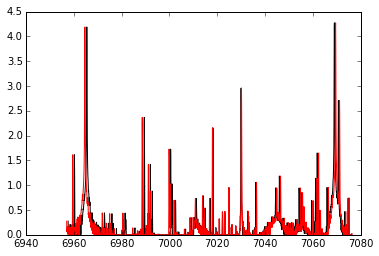

In [115]:
plt.plot( wavsol, logarcspec, 'k-' )
plt.plot( roughwav, logarcspec, 'r-' )
plt.show()
